# Baseline classifiers
Plan
1. EDA of the Papyrus1K dataset, select target of interest
2. Create a dataframe for particular target that has SMILES and corresponding label
3. Substitute the SMILES column with the set of features columns for classifier
4. Train a classifier
5. Collect metrics, primarily MCC (matthews_corrcoef)

## 1. Exploratory Data Analysis

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
import pickle

In [3]:
path_parquet = Path("../data/2023_09_12_papyrus1k_dataset_more_params_STD_MFP_lessColumns.parquet")
assert path_parquet.exists()

In [4]:
df = pl.read_parquet(path_parquet)
df.head()

target_id,class_label,STD_SMILES,STD_SELFIES,split
str,i64,str,str,str
"""B2RXH2_WT""",0,"""Oc1ccccc1C=NNC(=S)NC1CC2C=CC1C…","""[O][C][=C][C][=C][C][=C][Ring1…","""train"""
"""P00352_WT""",0,"""Oc1ccccc1C=NNC(=S)NC1CC2C=CC1C…","""[O][C][=C][C][=C][C][=C][Ring1…","""train"""
"""P43220_WT""",0,"""Oc1ccccc1C=NNC(=S)NC1CC2C=CC1C…","""[O][C][=C][C][=C][C][=C][Ring1…","""train"""
"""P51450_WT""",0,"""Oc1ccccc1C=NNC(=S)NC1CC2C=CC1C…","""[O][C][=C][C][=C][C][=C][Ring1…","""train"""
"""Q03164_WT""",0,"""Oc1ccccc1C=NNC(=S)NC1CC2C=CC1C…","""[O][C][=C][C][=C][C][=C][Ring1…","""train"""


In [5]:
c = Counter(df["target_id"])

In [6]:
# sort by count in descending order
c = {k: v for k, v in sorted(c.items(), key=lambda item: item[1], reverse=True)}
c

{'Q03431_WT': 41063,
 'Q9NUW8_WT': 26271,
 'Q16637_WT': 23397,
 'Q194T2_WT': 23366,
 'P51450_WT': 19758,
 'P00352_WT': 19538,
 'P02791_WT': 14727,
 'Q962Y6_WT': 13479,
 'P42336_WT': 11686,
 'Q9F4F7_WT': 11633,
 'P51151_WT': 11559,
 'P00533_WT': 10060,
 'O15118_WT': 9479,
 'Q16539_WT': 9266,
 'P08684_WT': 8576,
 'P48736_WT': 8566,
 'P97697_WT': 8458,
 'Q03164_WT': 8352,
 'P24941_WT': 8220,
 'Q12809_WT': 8103,
 'P04637_WT': 8002,
 'Q99714_WT': 7426,
 'Q13526_WT': 7097,
 'Q9Y468_WT': 6925,
 'P35968_WT': 6895,
 'P15428_WT': 6670,
 'P14618_WT': 6595,
 'O00329_WT': 6569,
 'P06746_WT': 6313,
 'P10636_WT': 6101,
 'O75604_WT': 5809,
 'P25779_WT': 5548,
 'P14416_WT': 5028,
 'P34972_WT': 4992,
 'P63092_WT': 4971,
 'P00918_WT': 4917,
 'P53350_WT': 4895,
 'P49841_WT': 4889,
 'P28482_WT': 4621,
 'P03372_WT': 4610,
 'O42275_WT': 4566,
 'Q9NR56_WT': 4551,
 'P00915_WT': 4518,
 'P42338_WT': 4449,
 'B2RXH2_WT': 4427,
 'Q16790_WT': 4285,
 'P29274_WT': 4276,
 'Q72547_WT': 4214,
 'O60674_WT': 4167,
 'P21554

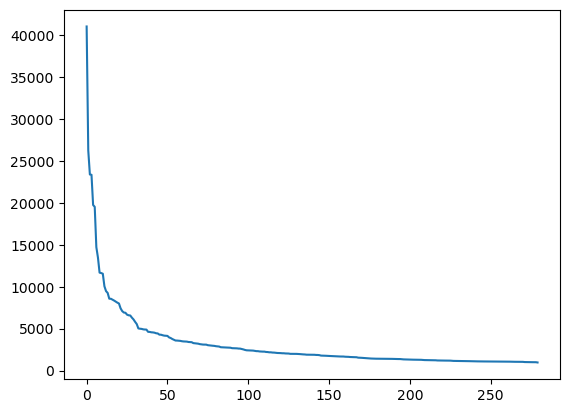

In [7]:
plt.plot(c.values());

In [8]:
target_id = "Q05397_WT"
assert target_id in df["target_id"]

## 2. Dataframe for a particular `target_id`

In [9]:
df_ = df.filter(pl.col("target_id") == target_id)
# drop columns that are not needed: "target_id", "STD_SELFIES"
df_ = df_.drop(["target_id", "STD_SELFIES"])

In [10]:
df_

class_label,STD_SMILES,split
i64,str,str
1,"""COc1cc(O)c(C(=O)O)c(-c2cc(O)c(…","""train"""
0,"""O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)…","""train"""
0,"""O=c1c(O)c(-c2ccc(O)c(O)c2)oc2c…","""train"""
0,"""COC1C(N(C)C(=O)c2ccccc2)CC2OC1…","""train"""
0,"""Cc1cc(C(C)Nc2ccccc2)c2nc(N3CCO…","""train"""
…,…,…
0,"""O=[N+]([O-])c1ccc(CSc2nnc(Cn3n…","""train"""
1,"""CCN1CCC(c2ccc(Nc3ncc(C(F)(F)F)…","""train"""
1,"""COc1cc(C(=O)NC2CCN(C)CC2)ccc1N…","""train"""


## 3. Create a table with features

In [11]:
path_fps = Path("../out/fingerprints_dicts/d_morgan.pkl")
assert path_fps.exists()

In [12]:
with open(path_fps, "rb") as f:
    d_morgan = pickle.load(f)

In [13]:
d_morgan

{'Oc1ccccc1C=NNC(=S)NC1CC2C=CC1C2': array([0, 0, 0, ..., 0, 0, 0]),
 'CC1C(=O)NN=C1C(=O)NN=Cc1ccc(O)cc1O': array([0, 0, 0, ..., 0, 0, 0]),
 'CCCC(=O)N1CCCC(n2cc(-c3cc(C(=O)O)ccn3)nn2)C1': array([0, 0, 0, ..., 0, 0, 0]),
 'CC1(C)Cc2nc(S)c(C#N)cc2CO1': array([0, 0, 0, ..., 0, 0, 0]),
 'O=C(c1ccccc1F)N1CCN(Cc2ccccc2F)CC1': array([0, 0, 0, ..., 0, 0, 0]),
 'Cc1cc(C=C2C(=N)N3C(=NC2=O)SN=C3S(C)(=O)=O)c(C)n1-c1ccc(F)cc1': array([0, 0, 0, ..., 0, 0, 0]),
 'Oc1cc(NCCN2CCOCC2)cc2cccnc12': array([0, 0, 0, ..., 0, 0, 0]),
 'Cc1ccc(S(=O)(=O)N2CCCCC2)cc1NC(=O)CSc1nc[nH]n1': array([0, 0, 0, ..., 0, 0, 0]),
 'Cc1cc(NC(=O)NC2(C(F)(F)F)Oc3ccc(Cl)cc3O2)no1': array([0, 0, 0, ..., 0, 0, 0]),
 'CCC(=O)NC(c1ccc2c(c1)OCO2)c1cc(Cl)c2cccnc2c1O': array([0, 1, 0, ..., 0, 0, 0]),
 'CC1=NN(c2ccccc2)C(=O)C1=Cc1ccc(Oc2ccc([N+](=O)[O-])cc2[N+](=O)[O-])cc1': array([0, 0, 0, ..., 0, 0, 0]),
 'O=C(NN=C1CCN(Cc2ccccc2)CC1)c1cc2ccccc2cc1O': array([0, 0, 0, ..., 0, 0, 0]),
 'O=S(=O)(c1ccccc1F)N1CCN(Cc2nc3ccccc3[nH]2)CC1': ar

In [14]:
df_.with_columns(
    morgan_fp = pl.col("STD_SMILES").map_elements(lambda x: d_morgan[x])
)

class_label,STD_SMILES,split,morgan_fp
i64,str,str,object
1,"""COc1cc(O)c(C(=O)O)c(-c2cc(O)c(…","""train""",[0 0 0 ... 0 0 0]
0,"""O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)…","""train""",[0 0 0 ... 0 0 0]
0,"""O=c1c(O)c(-c2ccc(O)c(O)c2)oc2c…","""train""",[0 0 0 ... 0 0 0]
0,"""COC1C(N(C)C(=O)c2ccccc2)CC2OC1…","""train""",[0 0 0 ... 0 0 0]
0,"""Cc1cc(C(C)Nc2ccccc2)c2nc(N3CCO…","""train""",[0 1 0 ... 0 0 0]
…,…,…,…
0,"""O=[N+]([O-])c1ccc(CSc2nnc(Cn3n…","""train""",[0 0 0 ... 0 0 0]
1,"""CCN1CCC(c2ccc(Nc3ncc(C(F)(F)F)…","""train""",[0 0 0 ... 0 0 0]
1,"""COc1cc(C(=O)NC2CCN(C)CC2)ccc1N…","""train""",[0 0 0 ... 0 0 0]
